In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import contourpy
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import networkx as nx
from _FigureJiazeHelper import *
from _DetectabilityWithMeta import *
from _CommunityDetect import *
from EXPERIMENT import *

%load_ext autoreload
%autoreload 2

In [3]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=10)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 10  # 'large'
plt.rcParams['lines.markersize'] = 12
plt.rcParams['axes.linewidth'] = 0.5

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [19]:
X = 2
Z = 3
n = X * Z * 200
d = 25
rho = 0.1
print(get_range_delta(d, n, X, Z))
delta = 0.1
pin = d / n + delta * (1 - 1 / (X * Z))
pout = d / n - delta / (X * Z)
pin = 0 if pin < 1e-10 else pin
pout = 0 if pout < 1e-10 else pout
msbm = SymMetaSBM(n, X, Z, rho, pin, pout)

(-0.025, 0.125)
Metadata generation done!


In [20]:
A = msbm.sample()
fullBHpartition, full_num_groups = CommunityDetect(A).BetheHessian()
print(f'FULL AMI is {adjusted_mutual_info_score(msbm.groupId, fullBHpartition)}')
partitionConcatenatedBysub = np.zeros(msbm.N)
num_partition = 0
for metaId in np.unique(msbm.metaId):
    filterA, filterGroupId = msbm.filter(A, metaId=metaId)
    subBHpartition, _ = CommunityDetect(filterA).BetheHessian()
    subBHpartition = num_partition + subBHpartition
    print(f'SUB AMI for meta {metaId} is {adjusted_mutual_info_score(filterGroupId, subBHpartition)}')
    num_partition += np.size(np.unique(subBHpartition))
    metaIndex = np.where(msbm.metaId == metaId)[0]
    for i, p in enumerate(subBHpartition):
        partitionConcatenatedBysub[metaIndex[i]] = p

number of groups = 6
FULL AMI is 1.0
number of groups = 3
SUB AMI for meta 0 is 0.855323674029379
number of groups = 3
SUB AMI for meta 1 is 0.8602313691126585


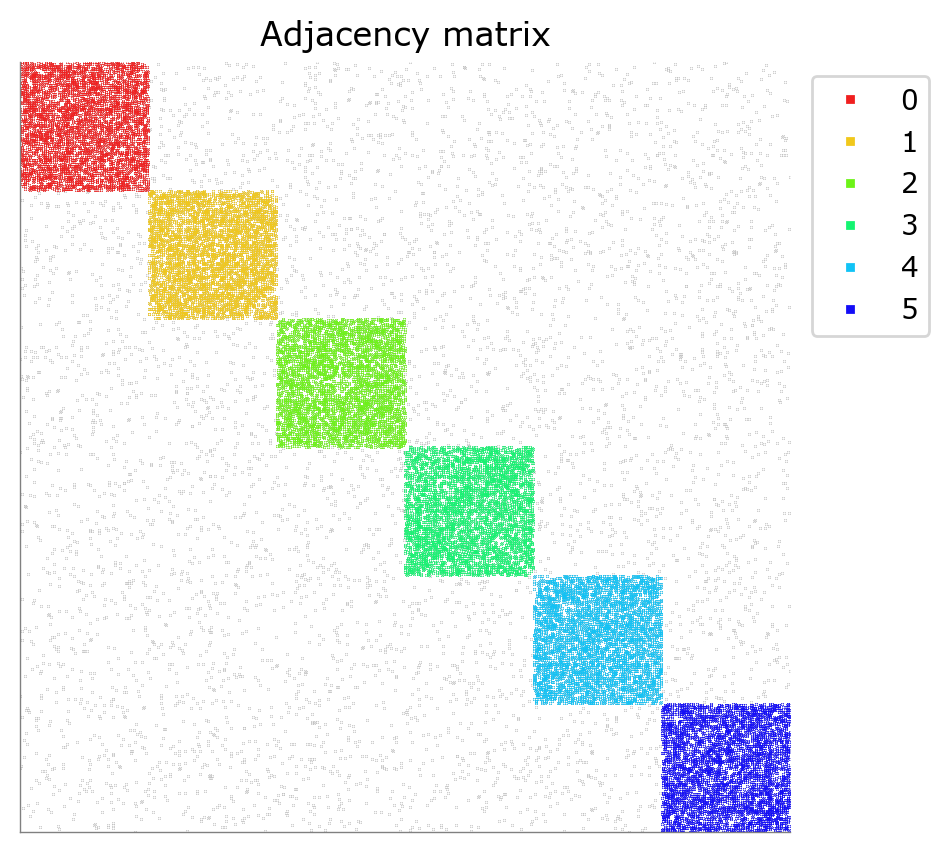

In [23]:
num_of_group = X * Z
group_sizes = np.array(msbm.sizes).flatten()
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=num_of_group)
plot_block_matrix(A.toarray(), partition_names=np.unique(msbm.groupId), partition_counts=group_sizes, colors=c, ms=0.01)

In [21]:
def draw_nx(g, nx_nodecolor, nx_pos=None):
    nx_pos = nx.spectral_layout(g, scale=5) if nx_pos is None else nx_pos
    nx.draw(g, pos=nx_pos, node_size=50, width=0.2, node_color=nx_nodecolor, with_labels=False, font_size=5)

True community


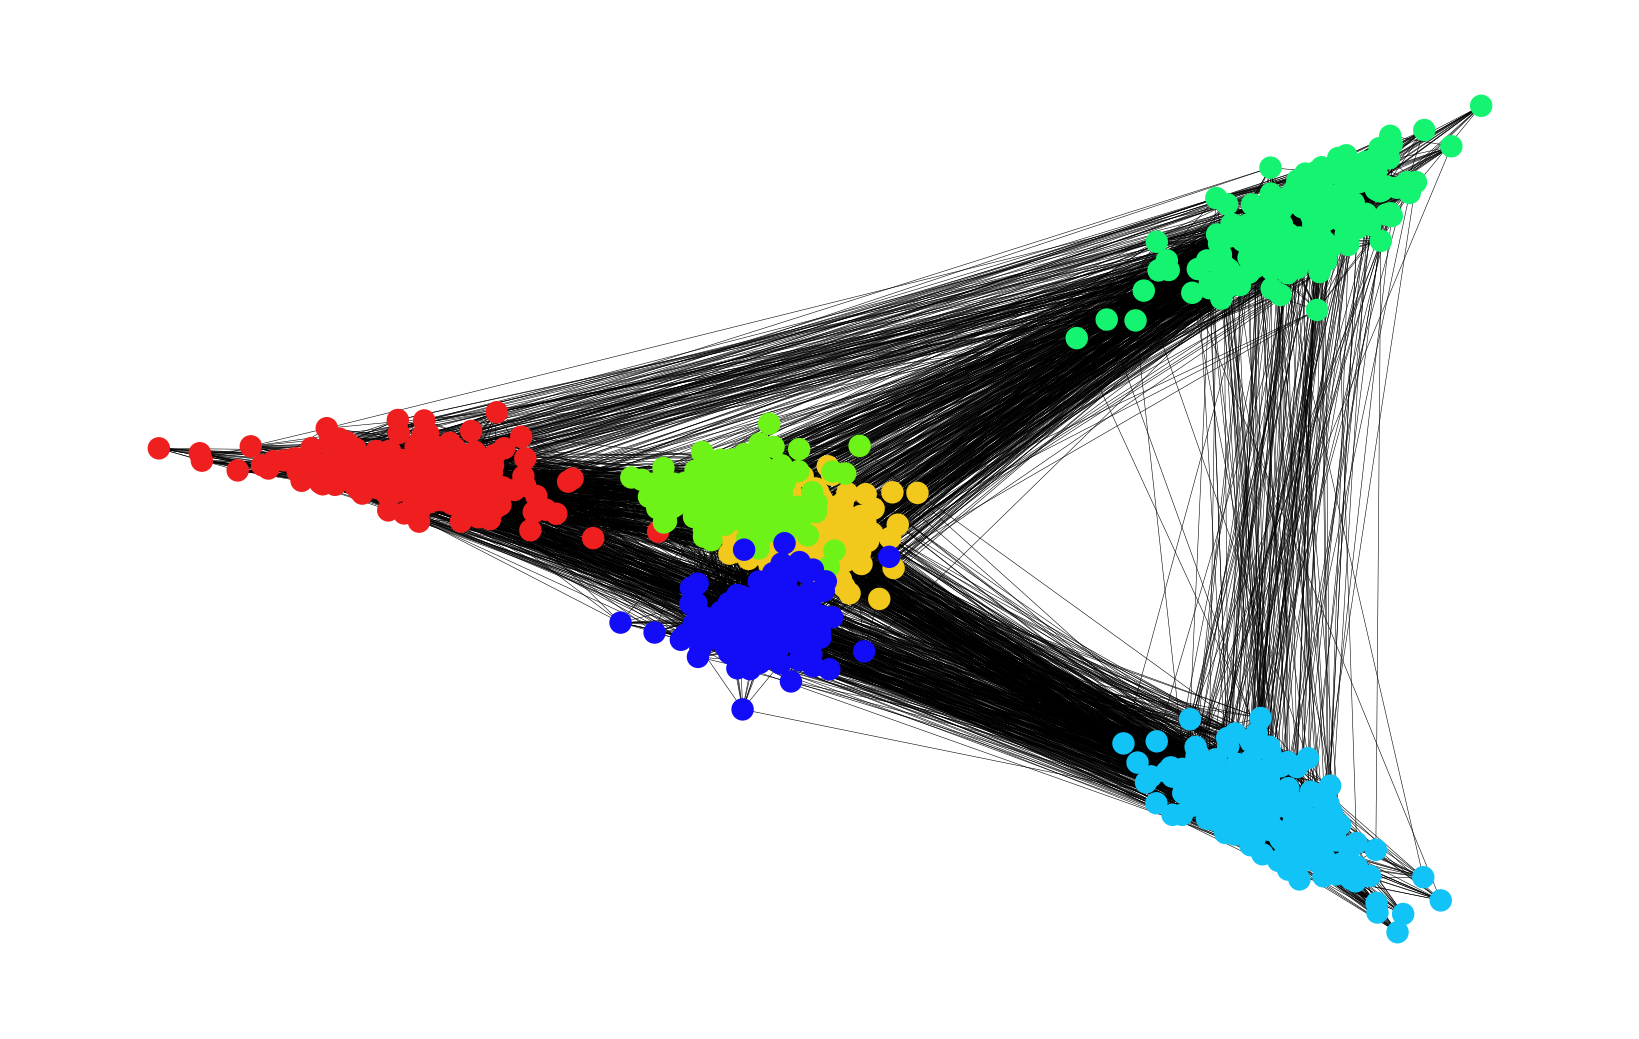

In [24]:
g = nx.from_scipy_sparse_array(A)
nx_pos = nx.spectral_layout(g, scale=5)
nx_nodecolor =  [c[msbm.groupId[i]] for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print("True community")

Full BH Community


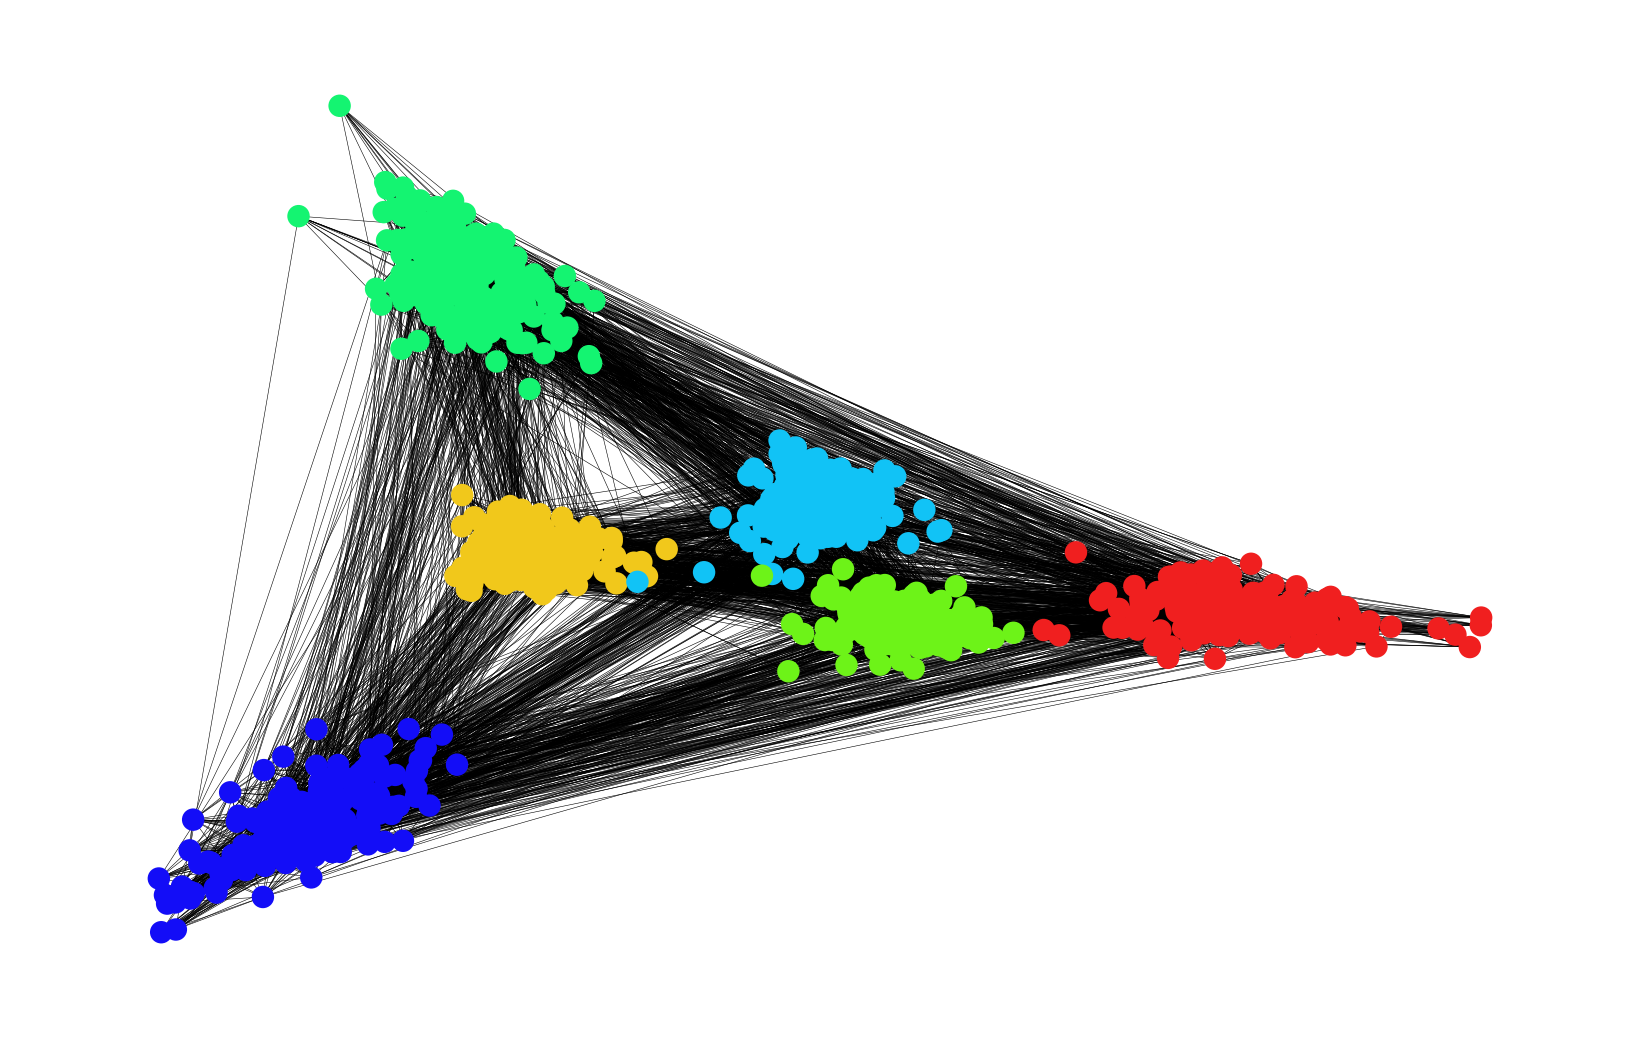

In [8]:
nx_nodecolor =  [c[fullBHpartition[i]] for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print("Full BH Community")

SUB BH concatenate Community, Number= 6


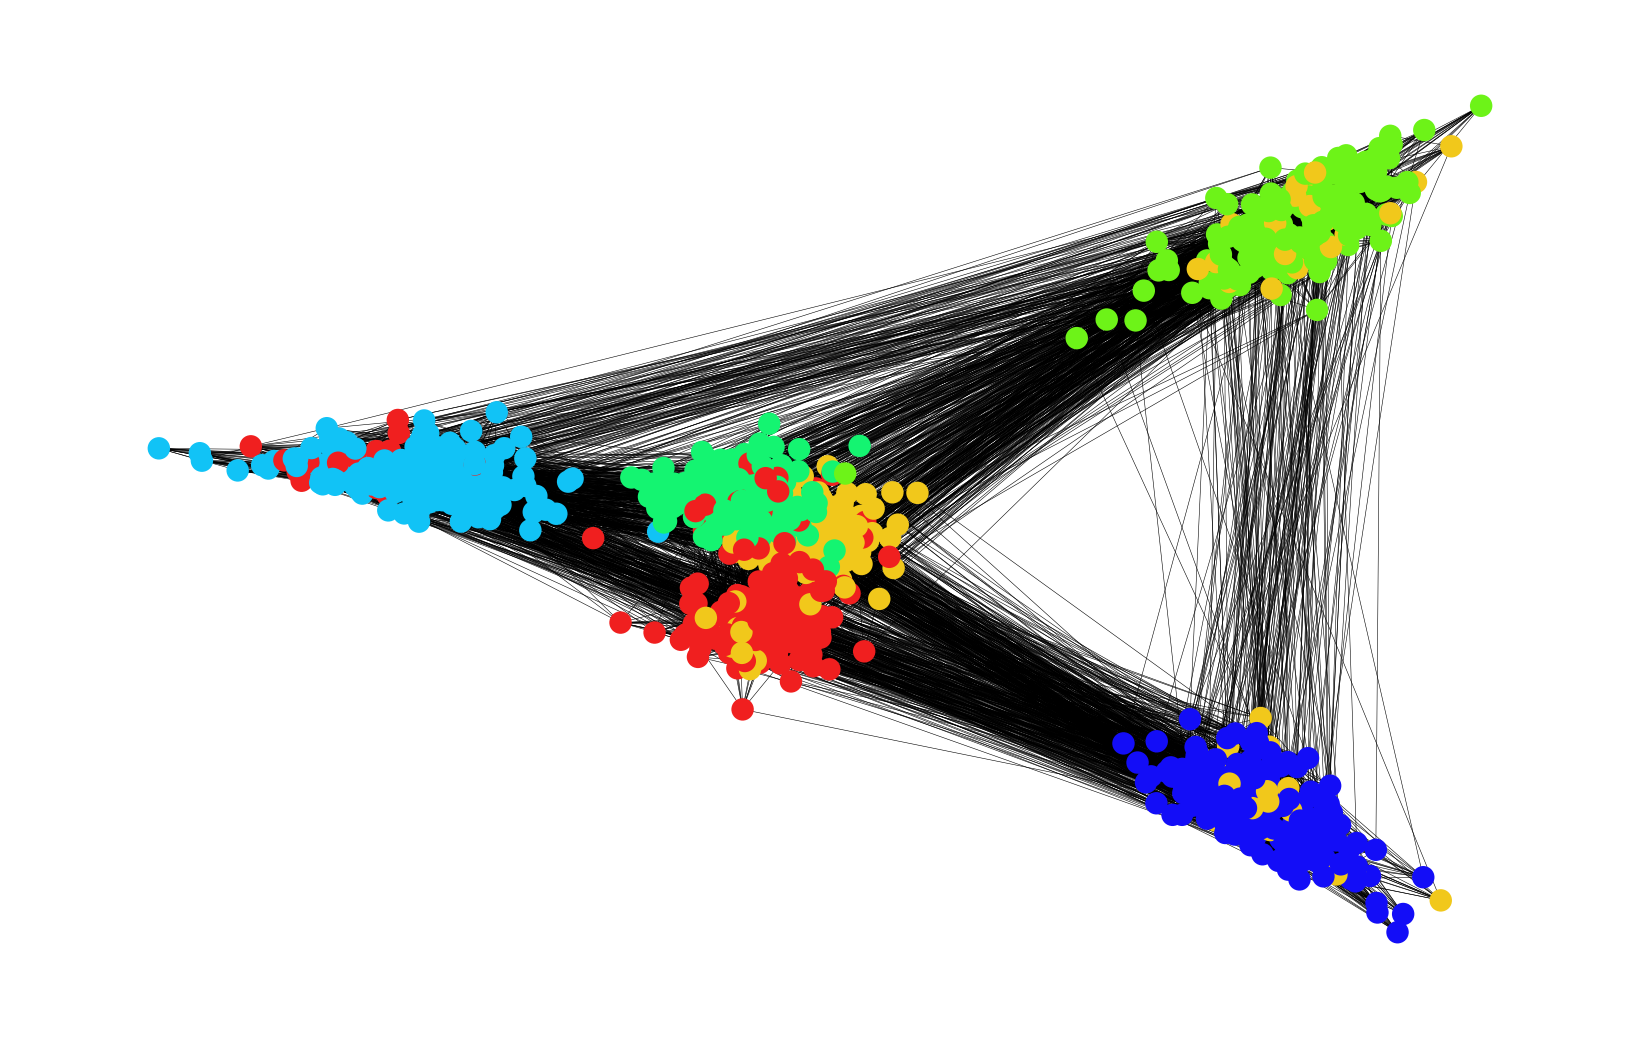

In [26]:
c_sub = gen_colors(start=colors_red[0], end=colors_blue[0], n=np.size(np.unique(partitionConcatenatedBysub)))
random.shuffle(c_sub)
print("SUB BH concatenate Community, Number=", np.size(np.unique(partitionConcatenatedBysub)))
nx_nodecolor =  [c_sub[int(partitionConcatenatedBysub[i])] for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
# print("SUB BH concatenate Community")

In [25]:
metaId = 0
_, filterGroupId = msbm.filter(A, metaId=metaId)
metaIndex = np.where(msbm.metaId == metaId)[0]
# subBHpartitionInFull = -1 + np.zeros(n)
# for i in range(np.size(filterGroupId)):
#     subBHpartitionInFull[metaIndex[i]] = partitionConcatenatedBysub[metaIndex[i]]
nx_nodecolor = [c_sub[int(partitionConcatenatedBysub[i])] if i in metaIndex else "gray" for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print("SUB by meta 0")

NameError: name 'c_sub' is not defined

SUB by meta 1


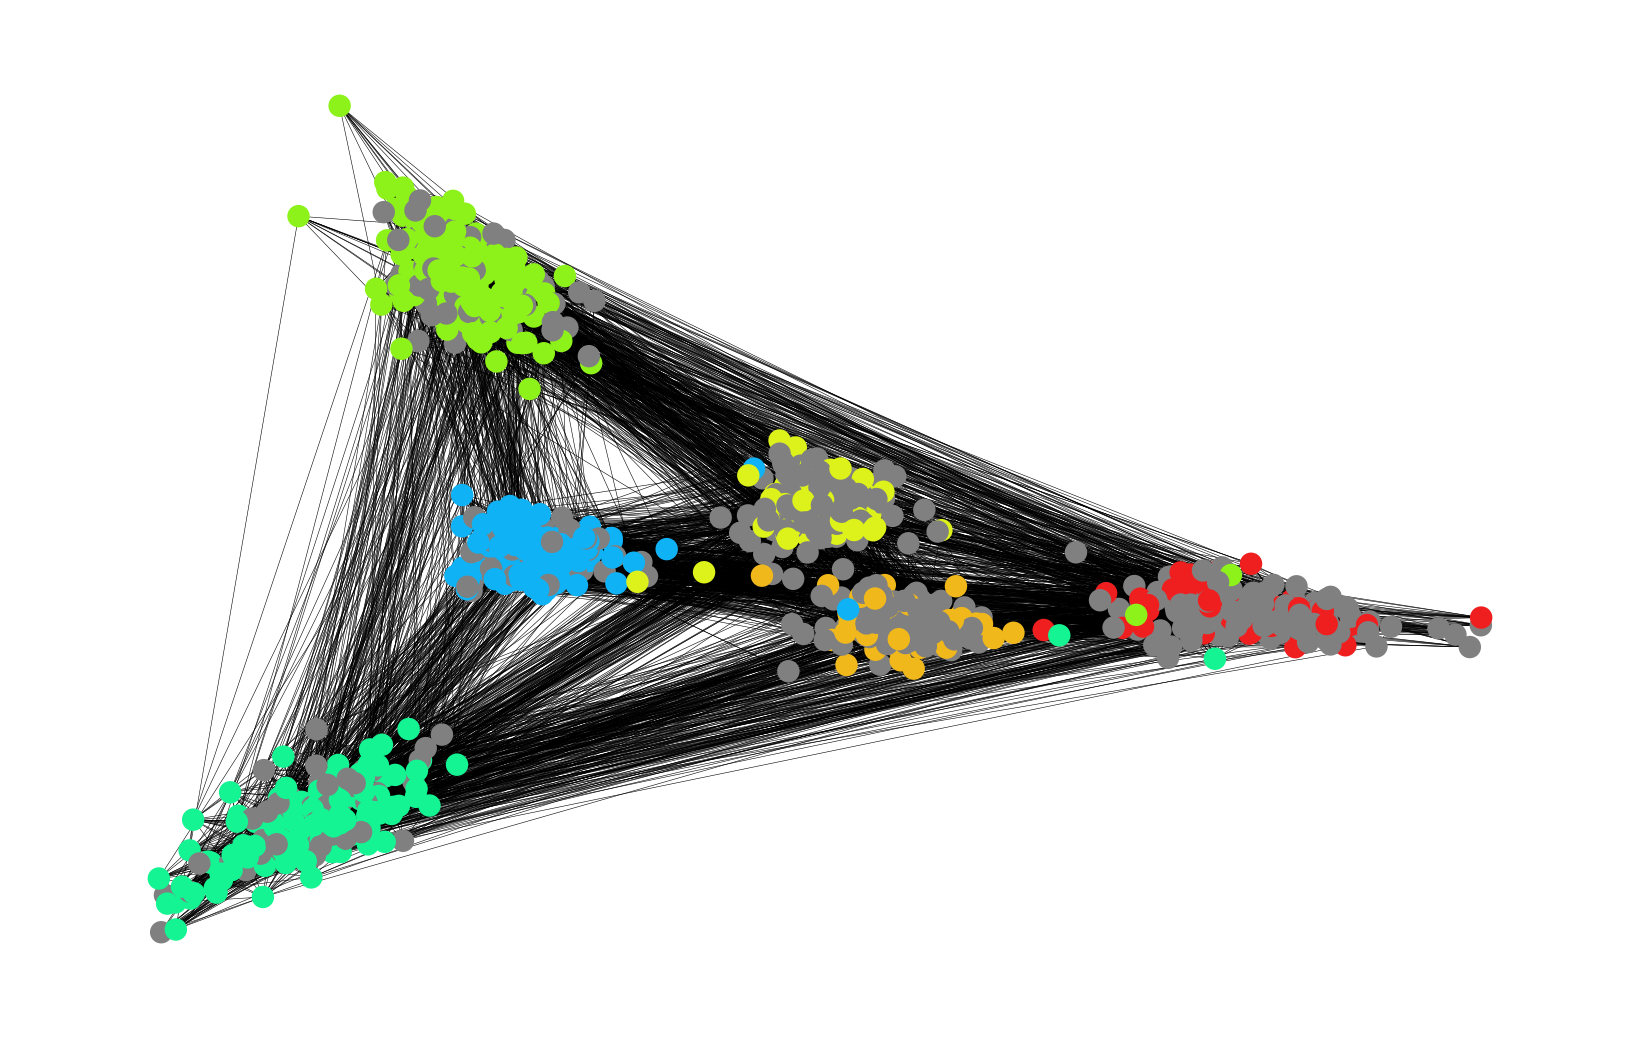

In [20]:
metaId = 1
_, filterGroupId = msbm.filter(A, metaId=metaId)
metaIndex = np.where(msbm.metaId == metaId)[0]
# subBHpartitionInFull = -1 + np.zeros(n)
# for i in range(np.size(filterGroupId)):
#     subBHpartitionInFull[metaIndex[i]] = partitionConcatenatedBysub[metaIndex[i]]
nx_nodecolor = [c_sub[int(partitionConcatenatedBysub[i])] if i in metaIndex else "gray" for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print("SUB by meta 1")

Iter0, Number of community detected 12


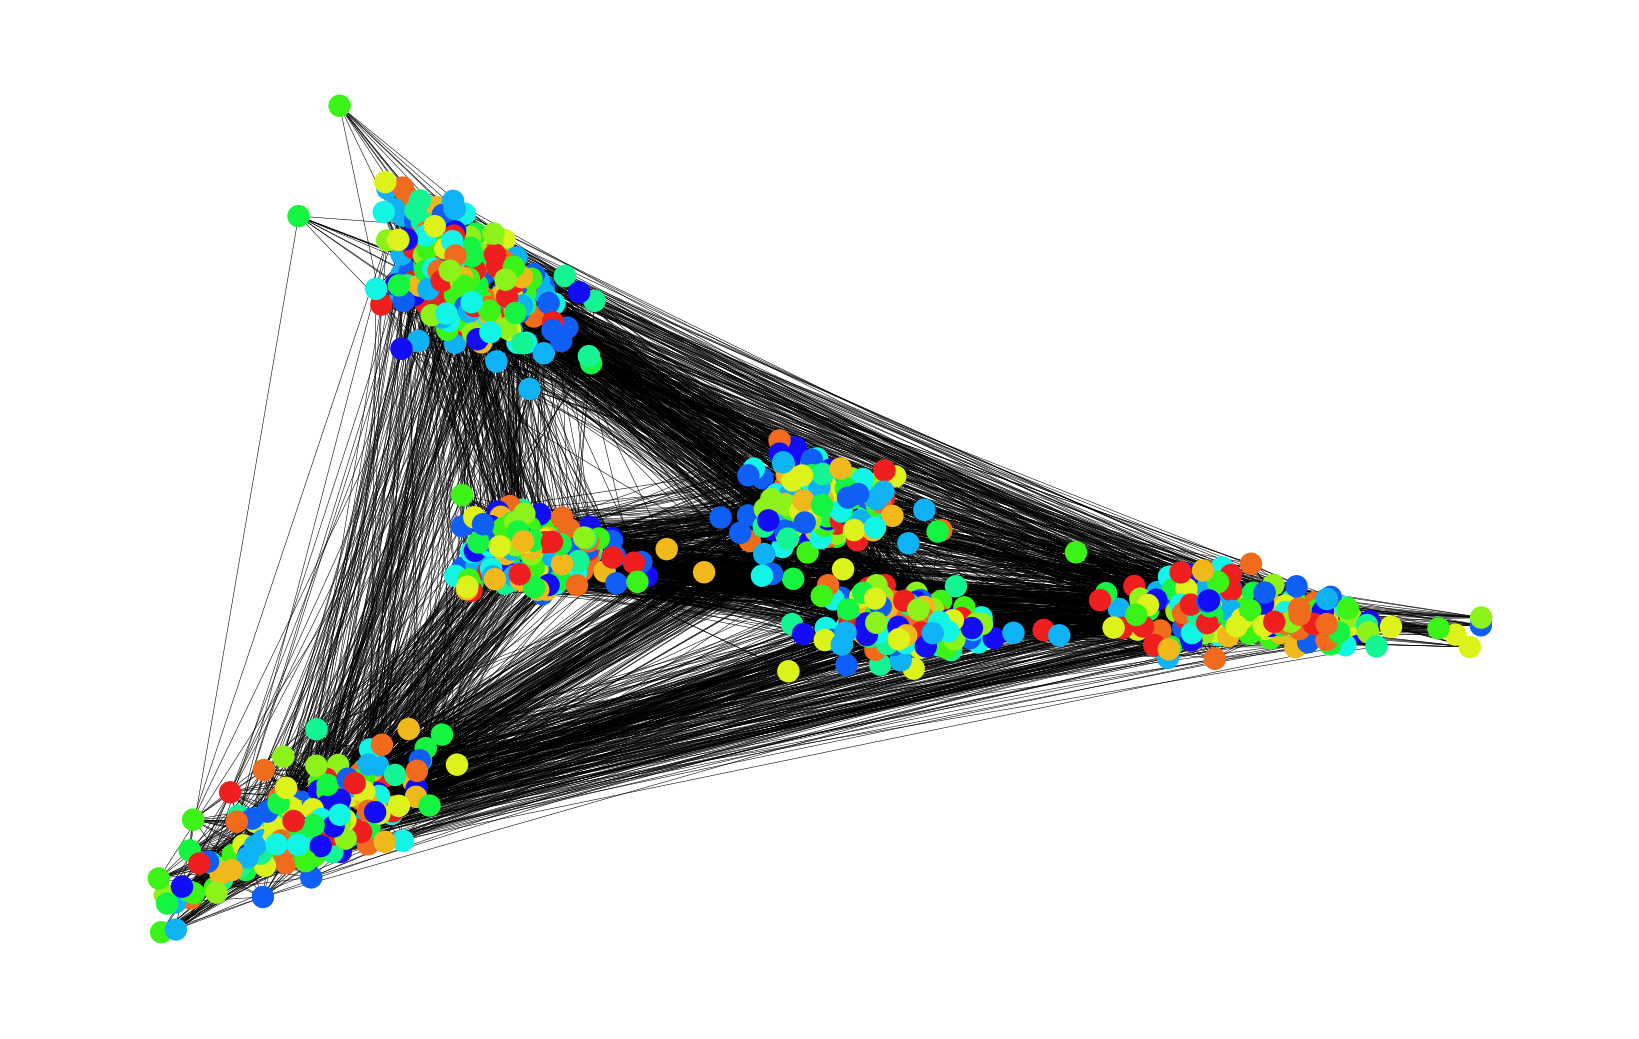

In [21]:
constrain_partition = partitionConcatenatedBysub
k = len(np.unique(constrain_partition))
nr_nodes = np.shape(A)[0]
H = sparse.coo_matrix((np.ones(nr_nodes), (np.arange(nr_nodes), constrain_partition)), shape=(nr_nodes, k)).tocsr()
alpha = 0.1
# Derive the full network partition by sub graph partition (By propagation)
propagation = TwoStepLabelPropagation(A, k, H, alpha=alpha)
iter_i = 0
subPropagationPartition = propagation.result()
nx_nodecolor =  [c_sub[int(subPropagationPartition[i])] for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print(f'Iter{iter_i}, Number of community detected {np.size(np.unique(subPropagationPartition))}')
last_F = np.copy(propagation.signal)

Iter0, Diff to last iter is 7.8572158653995094, Number of community detected 12


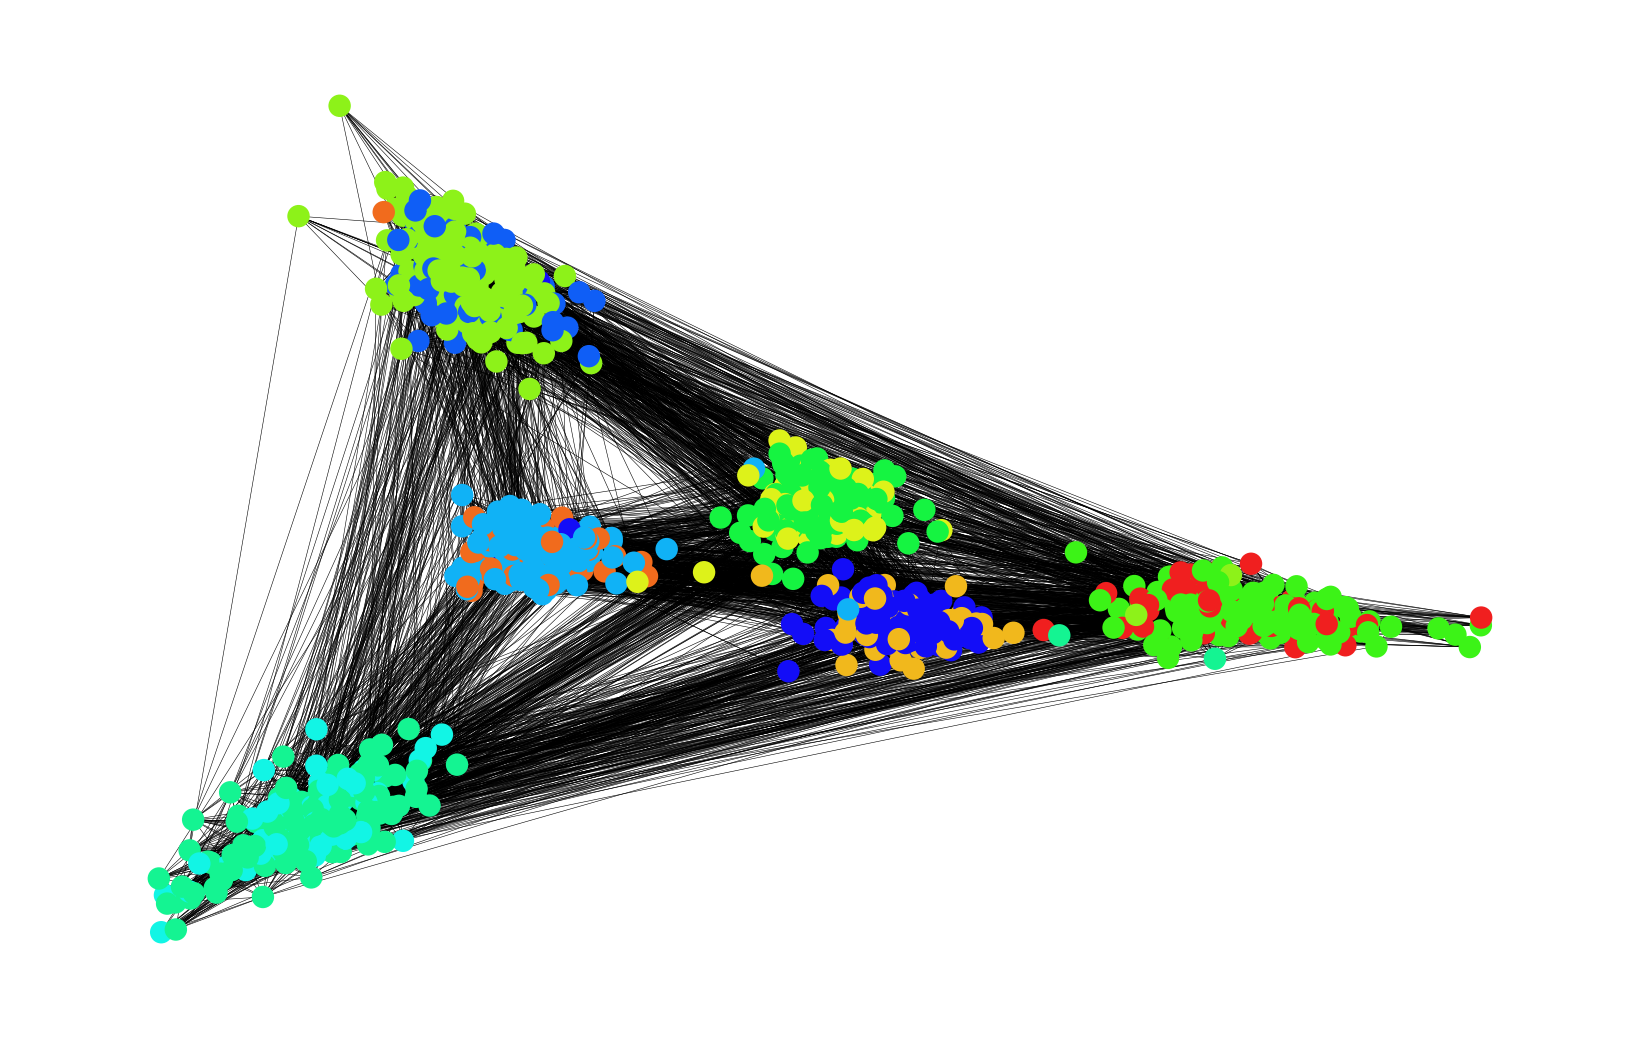

In [24]:
propagation.propagate()
diff = np.sum(np.abs(propagation.signal - last_F))
subPropagationPartition = propagation.result()
nx_nodecolor =  [c_sub[int(subPropagationPartition[i])] for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print(f'Iter{iter_i}, Diff to last iter is {diff}, Number of community detected {np.size(np.unique(subPropagationPartition))}')
last_F = np.copy(propagation.signal)

number of groups = 3
SUB AMI for meta 0 is 1.0


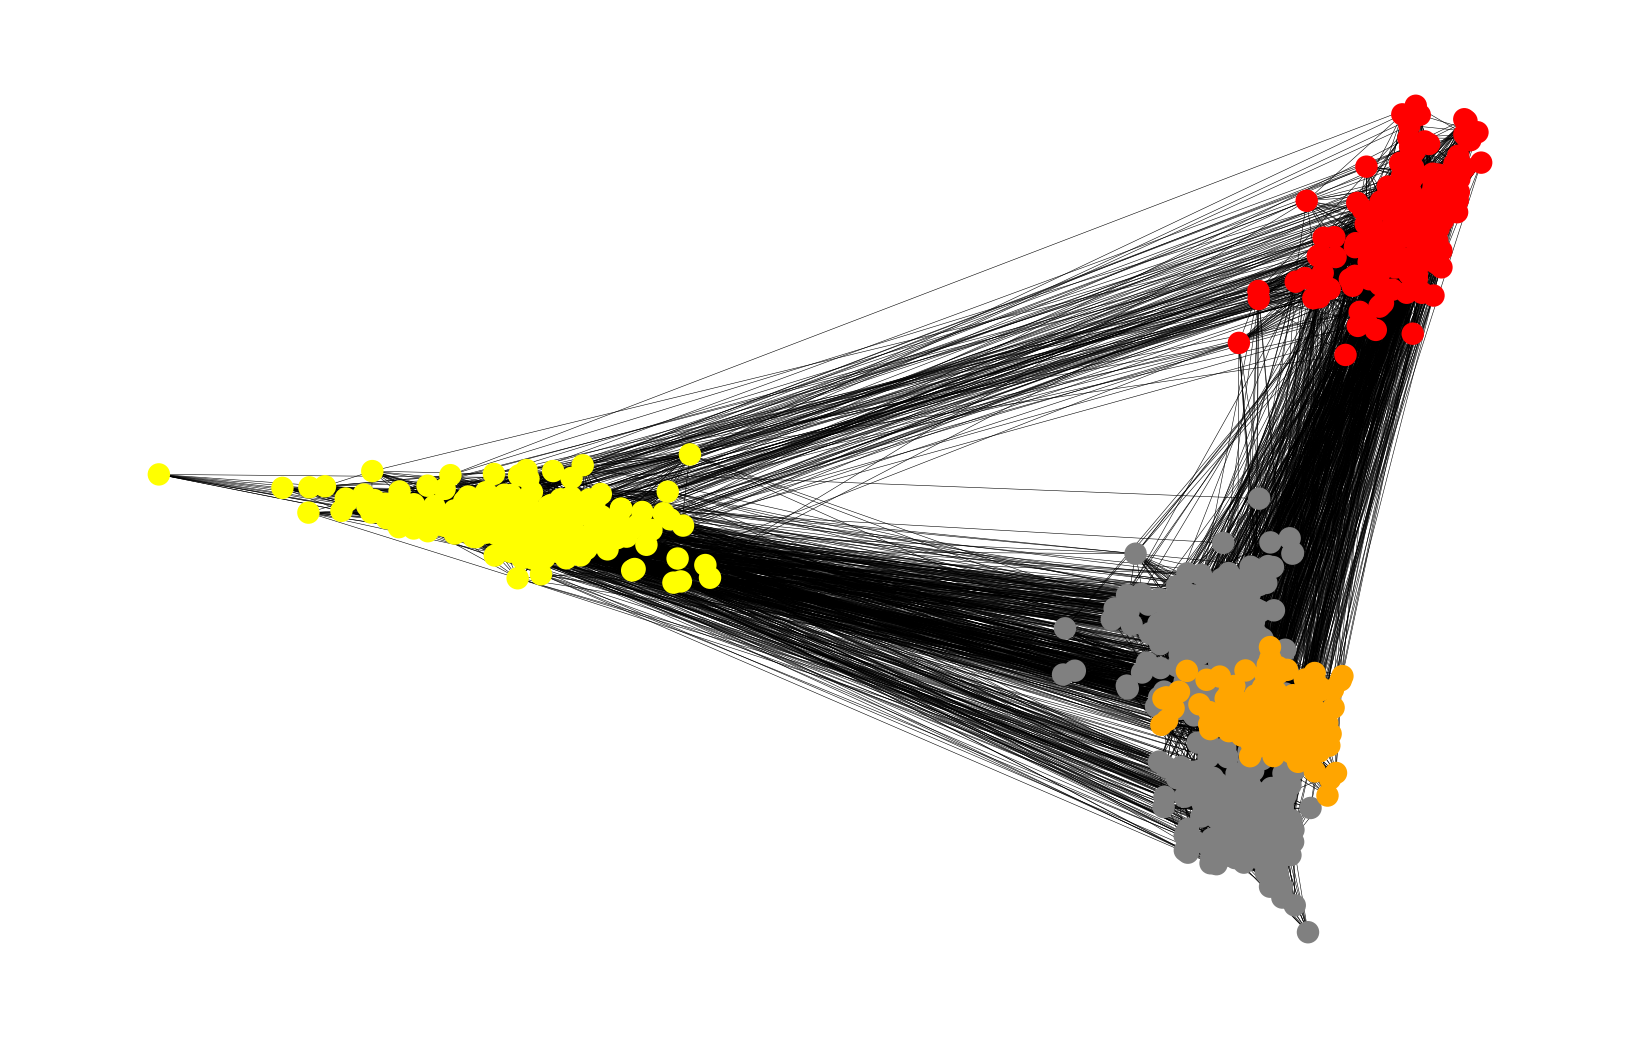

In [37]:
metaId = 0
filterA, filterGroupId = msbm.filter(A, metaId=metaId)
subBHpartition, _ = CommunityDetect(filterA).BetheHessian()
print(f'SUB AMI for meta {metaId} is {adjusted_mutual_info_score(filterGroupId, subBHpartition)}')
fullHalfPartition = -1 + np.zeros(msbm.N)
metaIndex = np.where(msbm.metaId == metaId)[0]
for i, p in enumerate(subBHpartition):
    fullHalfPartition[metaIndex[i]] = p
num_of_group = np.size(np.unique(subBHpartition))
num_of_group = 6
B = np.zeros((msbm.N, num_of_group))
for i, p in enumerate(fullHalfPartition):
    if p == -1:
        B[i, :] = B[i, :] + 1/num_of_group
    else:
        B[i, int(p)] = 1
# print(B)
B = sparse.csr_array(B)
c_sub = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
nx_nodecolor = [c_sub[int(fullHalfPartition[i])] if fullHalfPartition[i] != -1 else "gray" for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)

Iter0, Number of community detected 6


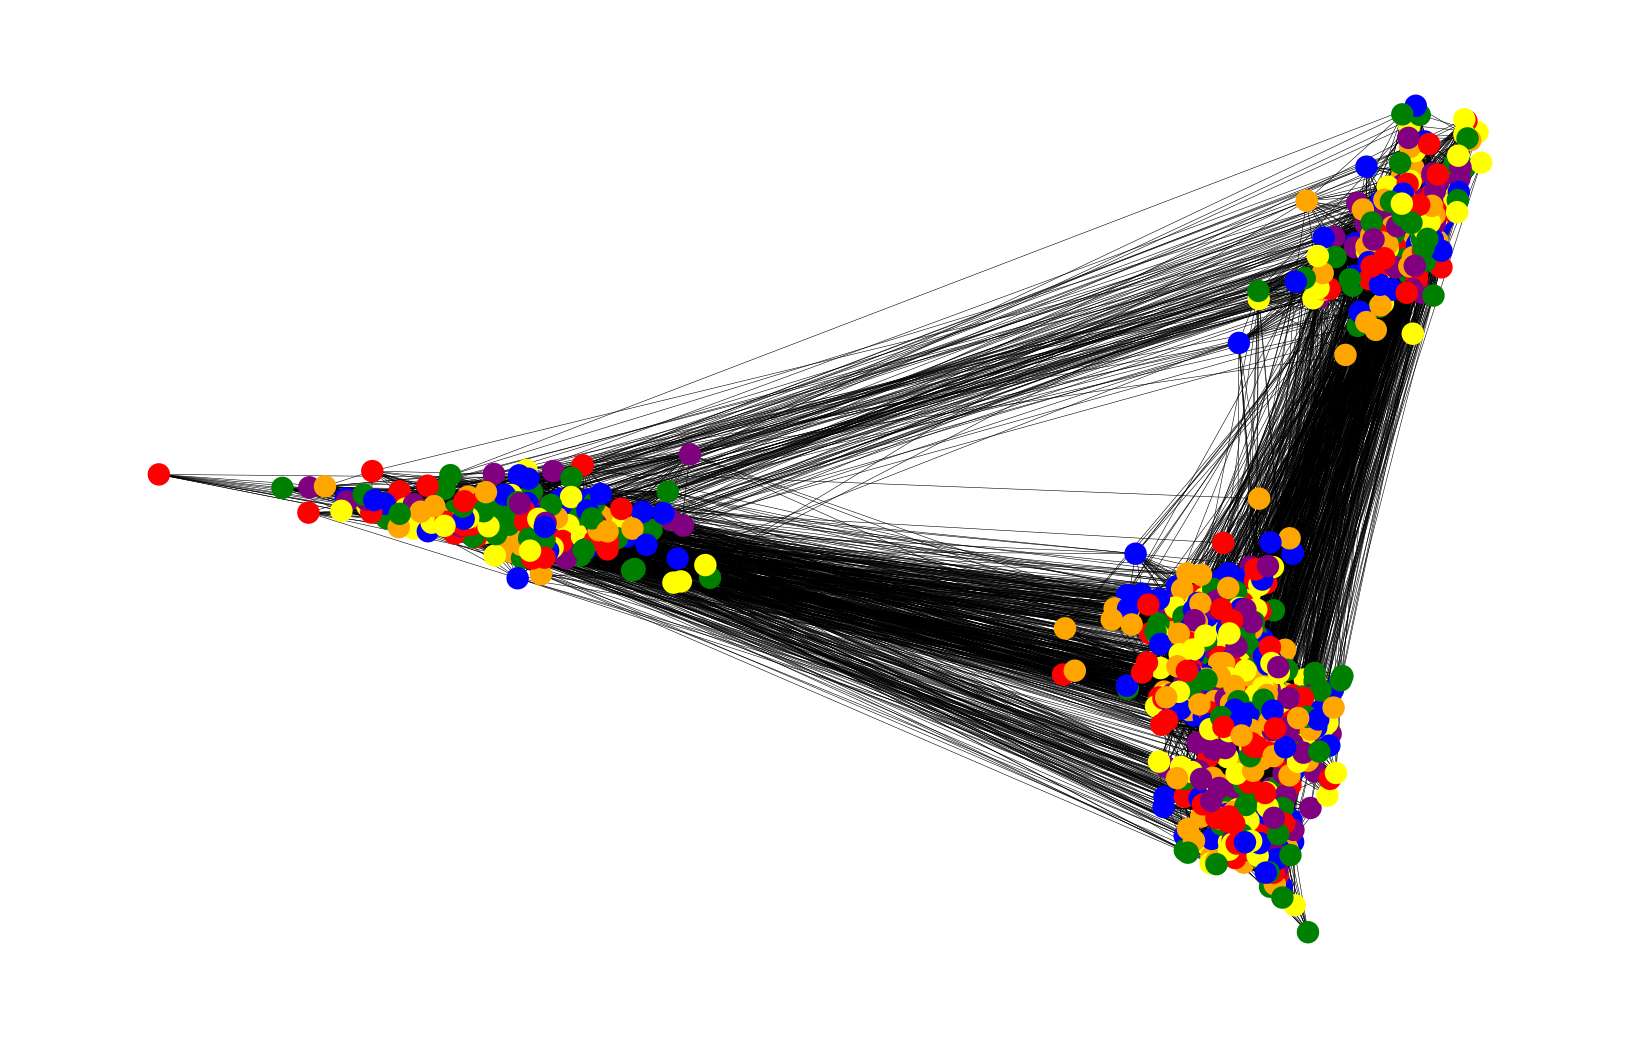

In [44]:
alpha = 0.9
num_of_group = 6
propagation = TwoStepLabelPropagation(A, num_of_group, B, alpha=alpha)
iter_i = 0
subPropagationPartition = propagation.result()
nx_nodecolor =  [c_sub[int(subPropagationPartition[i])] for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print(f'Iter{iter_i}, Number of community detected {np.size(np.unique(subPropagationPartition))}')
last_F = np.copy(propagation.signal)

Iter0, Diff to last iter is 35.79825281287166, Number of community detected 3


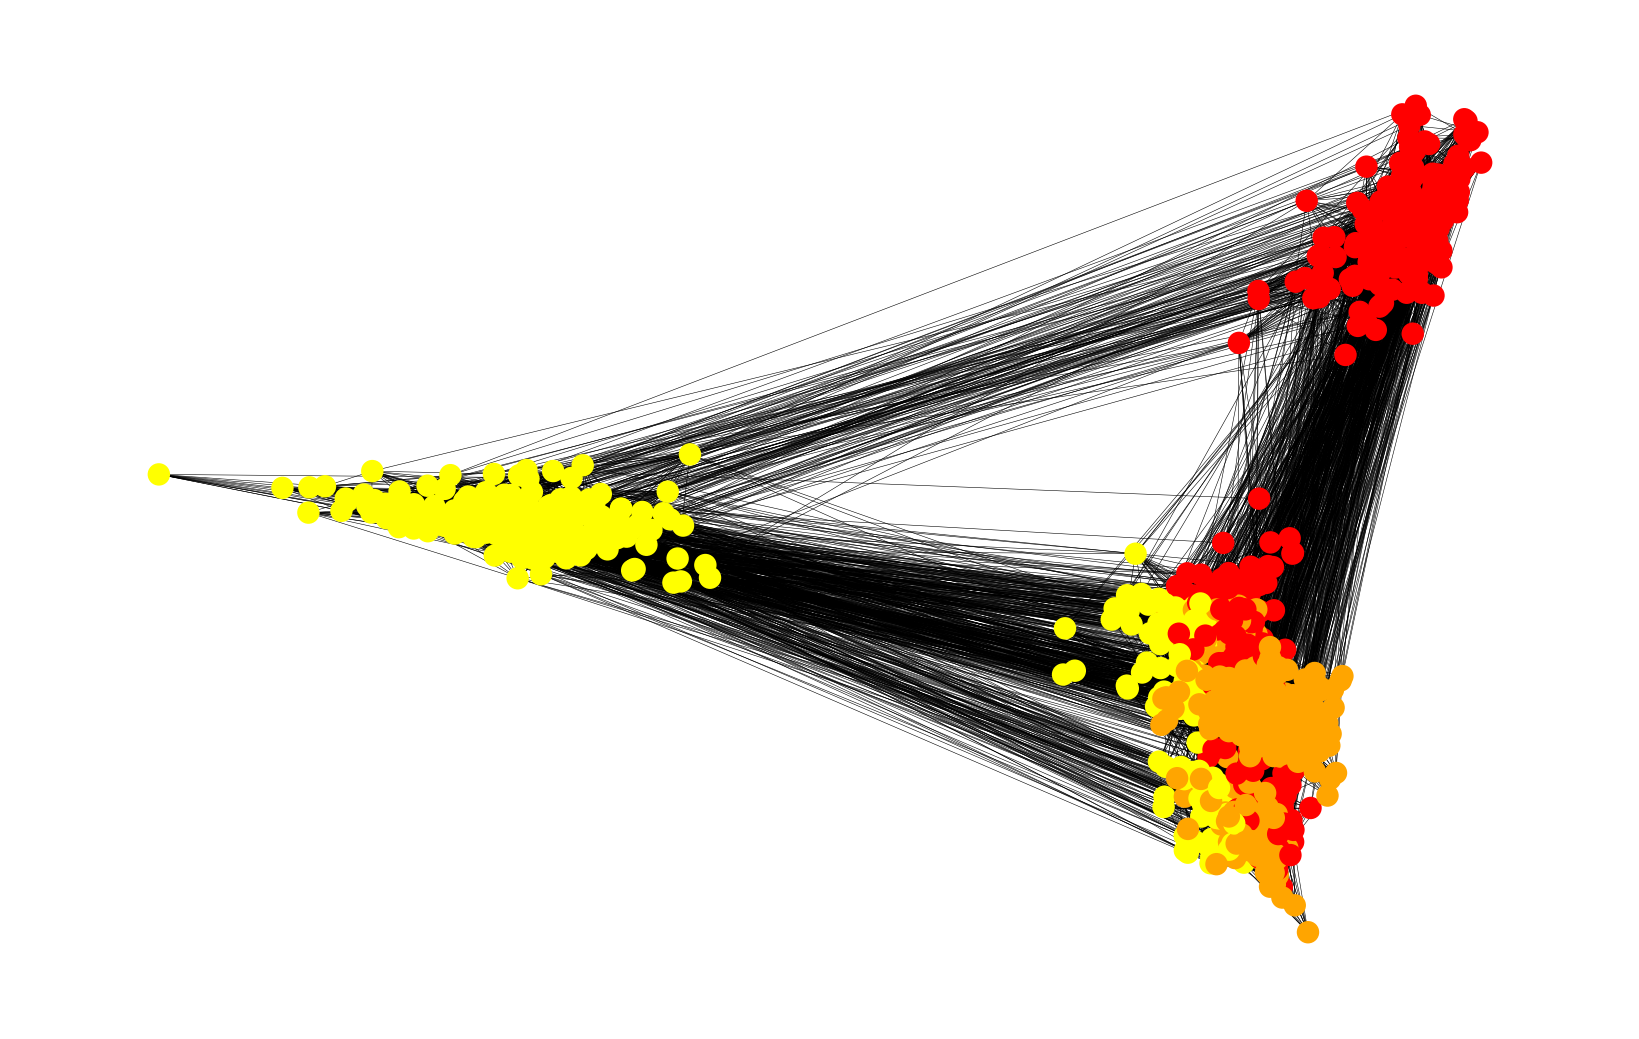

In [50]:
propagation.propagate()
diff = np.sum(np.abs(propagation.signal - last_F))
subPropagationPartition = propagation.result()
nx_nodecolor =  [c_sub[int(subPropagationPartition[i])] for i in range(n)]
draw_nx(g, nx_nodecolor, nx_pos=nx_pos)
print(f'Iter{iter_i}, Diff to last iter is {diff}, Number of community detected {np.size(np.unique(subPropagationPartition))}')
last_F = np.copy(propagation.signal)

In [6]:
# For big n
X = 2
Z = 3
n = X*Z*2000
d = 50
Withsnr = True
givenNumGroup = False
DC = False
HelpWithFull = False
LabelPropagate = True
fileId = 'amiExp6.12' + f'_n={n}_X={X}_Z={Z}_d={round(d)}_{"snr" if Withsnr else ""}_' \
                 f'{"givenNumGroup" if givenNumGroup else ""}_' \
                 f'{"DC" if DC else ""}_{"HelpWithFull" if HelpWithFull else ""}_' \
                 f'{"LabelPropagate" if LabelPropagate else ""}'
load_path = "./result/detectabilityWithMeta/" + fileId + ".txt"
addfileId = 'amiExp8.8' + f'_n={n}_X={X}_Z={Z}_d={round(d)}_{"snr" if Withsnr else ""}_' + \
                 f'{"givenNumGroup" if givenNumGroup else ""}_' + \
                 f'{"DC" if DC else ""}_{"HelpWithFull" if HelpWithFull else ""}_' + \
                 f'{"LabelPropagate" if LabelPropagate else ""}' + '_add'
addload_path = "./result/detectabilityWithMeta/" + addfileId + ".txt"
plot_rhos, plot_zs, full_ami_0, sub_ami_0, snr_nm, snr_m, full_num_group_0, sub_num_group_0 = read_exp(load_path=load_path, Withsnr=Withsnr, givenNumGroup=givenNumGroup, old=False, add_path=addload_path)
fileId = 'amiExp11.5' + f'_n={n}_X={X}_Z={Z}_d={round(d)}_{"snr" if Withsnr else ""}_' \
                            f'{"givenNumGroup" if givenNumGroup else ""}_' \
                            f'{"DC" if DC else ""}_{"HelpWithFull" if HelpWithFull else ""}_' \
                            f'{"LabelPropagate" if LabelPropagate else ""}'
load_path = "./result/detectabilityWithMeta/" + fileId + ".txt"
addload_path = None
plot_rhos, plot_zs, full_ami_1, sub_ami_1, snr_nm, snr_m_1, full_num_group_1, sub_num_group_1 = read_exp(load_path=load_path, Withsnr=Withsnr, givenNumGroup=givenNumGroup, old=False, add_path=addload_path)
print(np.shape(sub_num_group_0), np.shape(plot_rhos_0))

(3060,) (3060,)


Combine the result from read_exp which is after mean process


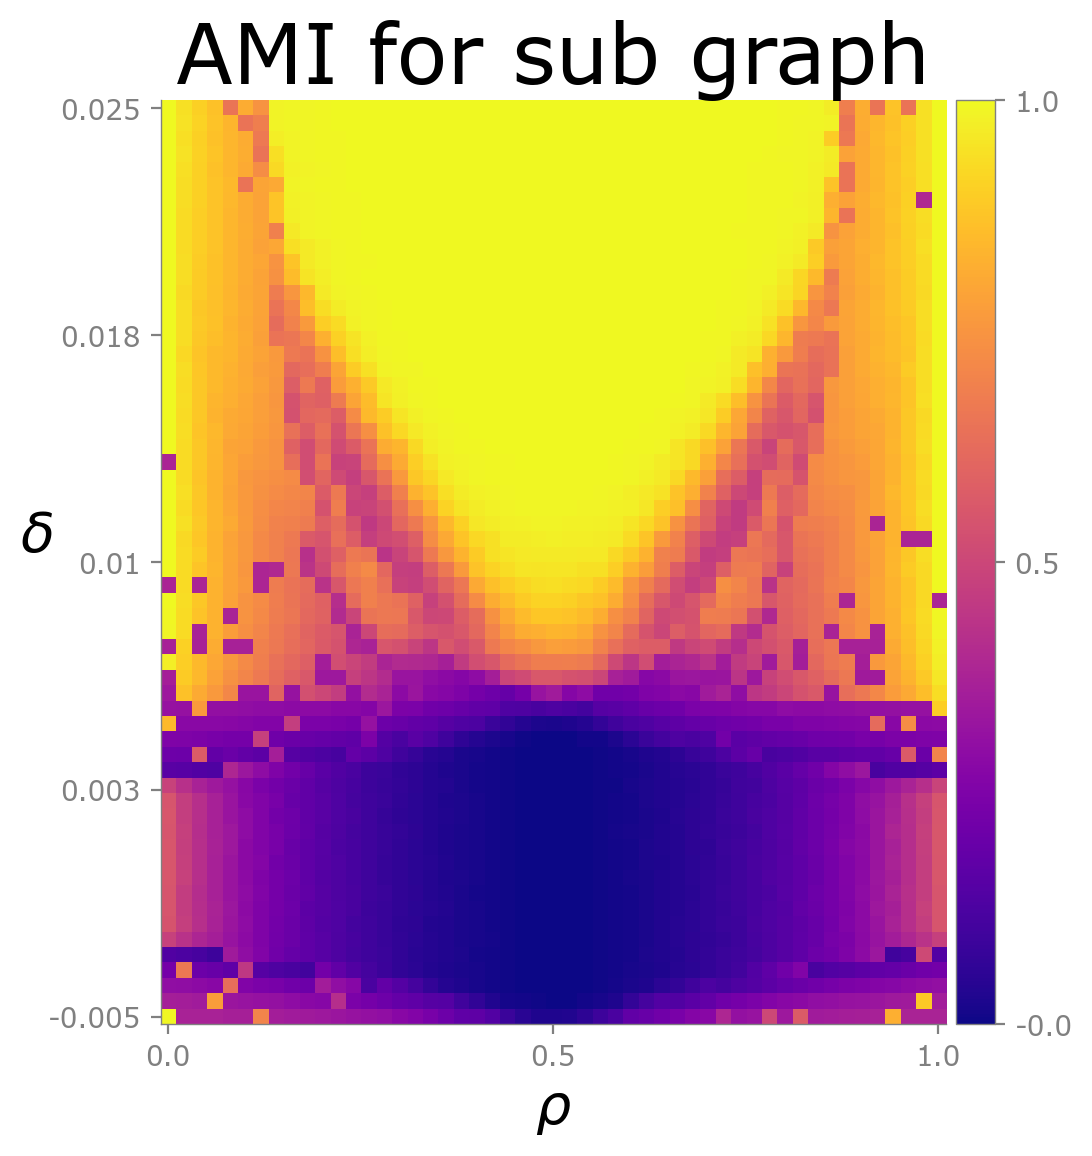

In [15]:
index_propagate_by_2sub = np.where(sub_num_group_0 <= 6)[0]
index_propagate_by_1sub = np.where(sub_num_group_0 > 6)[0]
sub_ami_propagate_combined = np.zeros(np.size(plot_rhos))
sub_ami_propagate_combined[index_propagate_by_2sub] = sub_ami_0[index_propagate_by_2sub]
sub_ami_propagate_combined[index_propagate_by_1sub] = sub_ami_1[index_propagate_by_1sub]
# print(index_propagate_by_1sub)
fig = plt.figure(figsize=(6, 6))
widths = [6]
heights = [6]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
cmap = mpl.colormaps["plasma"]
zcenter = 0.5
plot_subami = color_imshow_2d(plot_rhos, plot_zs, sub_ami_propagate_combined, z_center=zcenter, title="AMI for sub graph", xlabel=r'$\rho$', ylabel=r'$\delta$', cmap=cmap, ax=ax, fig=fig)
print("Combine the result from read_exp which is after mean process")

In [5]:
# For big n
X = 2
Z = 3
n = X*Z*2000
d = 50
Withsnr = True
givenNumGroup = False
DC = False
HelpWithFull = False
LabelPropagate = True
fileId = 'amiExp11.9' + f'_n={n}_X={X}_Z={Z}_d={round(d)}_{"snr" if Withsnr else ""}_' \
                            f'{"givenNumGroup" if givenNumGroup else ""}_' \
                            f'{"DC" if DC else ""}_{"HelpWithFull" if HelpWithFull else ""}_' \
                            f'{"LabelPropagate" if LabelPropagate else ""}_somebaseon1sub'
load_path = "./result/detectabilityWithMeta/" + fileId + ".txt"
plot_rhos, plot_zs, full_ami, sub_ami, snr_nm, snr_m, full_num_group, sub_num_group = read_exp(load_path=load_path, Withsnr=Withsnr, givenNumGroup=givenNumGroup, old=False)


Some parameter rho=0.36, z=0.0115 didn't run!
Some parameter rho=0.42, z=0.012 didn't run!
Some parameter rho=0.44, z=0.021 didn't run!
Some parameter rho=0.48, z=0.009 didn't run!
Some parameter rho=0.5, z=0.0065 didn't run!
Some parameter rho=0.5, z=0.007 didn't run!
Some parameter rho=0.5, z=0.025 didn't run!
Some parameter rho=0.52, z=0.007 didn't run!
Some parameter rho=0.52, z=0.0075 didn't run!
Some parameter rho=0.52, z=0.009 didn't run!
Some parameter rho=0.54, z=0.008 didn't run!
Some parameter rho=0.54, z=0.0105 didn't run!
Some parameter rho=0.54, z=0.011 didn't run!
Some parameter rho=0.54, z=0.024 didn't run!
Some parameter rho=0.54, z=0.025 didn't run!
Some parameter rho=0.56, z=0.0235 didn't run!


D:\BackProgram\Anaconda\envs\network\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\BackProgram\Anaconda\envs\network\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Some parameter rho=0.58, z=0.0095 didn't run!
Some parameter rho=0.58, z=0.011 didn't run!
Some parameter rho=0.58, z=0.025 didn't run!
Some parameter rho=0.62, z=0.0075 didn't run!
Some parameter rho=0.62, z=0.0085 didn't run!
Some parameter rho=0.62, z=0.01 didn't run!
Some parameter rho=0.66, z=0.0095 didn't run!
Some parameter rho=0.68, z=0.01 didn't run!
Some parameter rho=0.7, z=0.0245 didn't run!
